# RPZ Assignment: Parzen Window Probability Density Estimation

**Detailed BRUTE upload instructions at the end of this notebook.**

## Introduction

In this lab we continue building decision strategies, but again, the problem gets a bit more involved. Last time we met the situation when the prior probabilities were not known, but so far we were given all the distributions needed for making the optimal decision. In this lab we assume the probability density $p_{X|k}(x|k)$ is unknown. We will explore the situation when we know at least its parametric form in the next lab, but this time we are given only a set of measurements $\{x_1, \ldots, x_n\} \sim p_{X|k}(x|k)$, i.e. a set of independent identically distributed (i.i.d.) samples from this distribution.

Because we do not know the parameters of the distribution, we are about to use a so called _non-parametric_ kernel density method. In particular, you will implement the __[Parzen window method](https://en.wikipedia.org/wiki/Kernel_density_estimation)__. Because the class densities are independent, we can drop the class conditioning and consider an arbitrary distribution $p(x)$ instead.

The kernel density estimation $\hat{p}_h(x)$ of an unknown distribution $p(x)$ given a set $\{x_1, \ldots, x_n\} \sim p(x)$ of i.i.d measurements is defined as
$$
\hat{p}_h(x) = \frac{1}{n}\sum_{i=1}^n K_h(x - x_i)
$$
where $K_h$ is a kernel (a symmetric function that integrates to one) and $h$ is the kernel size (bandwidth). Different kernel functions __[can be used](https://en.wikipedia.org/wiki/Kernel_density_estimation)__, but we will use $K_h(x) \equiv N(0, h^2)$, i.e. the normal distribution with zero mean and standard deviation $h$.

Note that the kernel parameter $h$ does not make the method "parametric". The parameter defines smoothness of the estimate, not the form of the estimated distribution. Nevertheless, the choice of $h$ still influences the quality of the estimate as you will see below. Using __[cross-validation](https://en.wikipedia.org/wiki/Cross-validation%20(statistics))__ we will find such value of $h$ that ensures the estimate generalises well to previously unseen data.

Finally, using the above estimates of the probability density functions $p_{X|k}(x|k)$, we will once again build a Bayesian classifier for two letters and test it on an independent test set.

In [29]:
%load_ext autoreload
%autoreload 2

from parzen import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 1: Parzen window estimation

In this part we will implement the Parzen window density estimation method. We will inspect the result by comparing the estimate to a normalized histogram. We will experiment with the value of $h$ manually.

### Load data

Load the training `trn` and test `tst` parts of the data, each containing images and their correct labels. For both, the label 0 denotes an image of letter 'A' and label 1 an image of letter 'C'.

In [30]:
data = np.load("data_33rpz_parzen.npz", allow_pickle=True)
tst = data["tst"].item()
trn = data["trn"].item()

### Compute measurements

For measurements, we use the function `compute_measurement_lr_cont` from the previous assignements.

In [31]:
x = compute_measurement_lr_cont(trn['images'])

# splitting the trainning data into classes
idxs = np.squeeze(trn['labels'])
xA = x[idxs == 0]
xC = x[idxs == 1]

### Parzen estimate

Complete the template of the function `p = parzen(x, trn_x, h)` so that for a given $x$ (possibly a vector of values) it computes the Parzen estimate of probability density $p_{X|k}(x|k)$. Here, `trn_x` is a vector of training measurements for one of the classes (`xA` or `xC`) and $h$ is the kernel bandwidth. As the kernel function $K_h(x)$ use the normal distribution $N(0, h^2)$.

**Hint:** Use `scipy.stats.norm.pdf()` to calculate $K_h$. 

In [32]:
# Unit Test:
p = parzen(np.array([1, 2, 3]), np.array([-1, 0, 2, 1.5, 0]), 1.0)

np.testing.assert_array_almost_equal(p, [0.22639369, 0.17268428, 0.07609717], err_msg="Incorrect density estimate.")

### Visualize the density estimate

We are free to choose the bandwidth $h$. Let's explore how does the estimate differs for different values of $h$.

In [33]:
# computing the histograms of training data
hist_A, bins_A = np.histogram(xA, 20, density=True)
hist_C, bins_C = np.histogram(xC, 20, density=True)

In [34]:
# estimating conditional probability using Parzen window
x_range = np.arange(np.min(xA), np.max(xA), 100)
h = [100., 500., 1000., 2000.]

y = np.zeros([len(h), x_range.size], np.float64)
for i in range(len(h)):
    y[i,:] = parzen(x_range, xA, h[i])

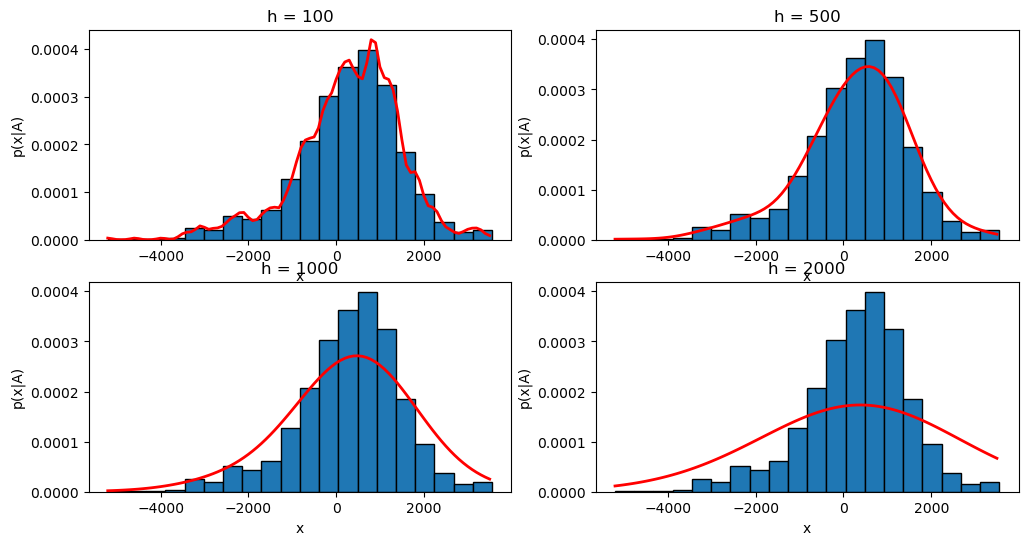

In [35]:
def plot_parzen(x, y, hist, bins, h=500., cls='A'):
    centers = (bins[:-1] + bins[1:]) / 2
    width = bins[:-1] - bins[1:]
    plt.bar(centers, hist, width=width, edgecolor='k')
    plt.plot(x.T, y.T, 'r', linewidth=2)
    plt.title('h = {:.0f}'.format(h))
    plt.xlabel('x')
    plt.ylabel('p(x|{})'.format(cls))

# plots of the estimates
plt.figure(figsize=(12,6))

for idx in range(4):
    cur_h = h[idx]
    plt.subplot(2,2,idx+1)
    plot_parzen(x_range, y[idx:(idx+1),:], hist_A, bins_A, h=cur_h)
    
plt.savefig('parzen_estimates.png')

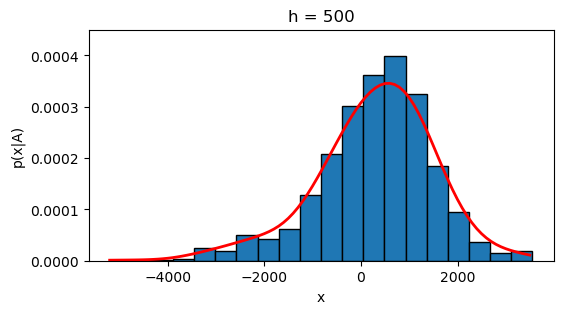

interactive(children=(FloatSlider(value=500.0, description='h', max=2000.0, min=10.0, step=10.0), Output()), _…

In [36]:
# Use the following piece of code for interactive density estimation visualization

# use this one in VSCode
%matplotlib inline
# and this one in PyCharm
# %matplotlib notebook

try:
    from ipywidgets import interact, interactive, fixed
    
    @interact(h=(10., 2000., 10.))
    def plot_parzen_interactive(h=500.):
        plt.figure(figsize=(6, 3))
        x_range = np.arange(np.min(xA), np.max(xA), 100)
        y = parzen(x_range, xA, h)
        plot_parzen(x_range, y, hist_A, bins_A, h=h)
        plt.ylim([0, 4.5e-4])

except ImportError:
    print('Optional feature.')

## Part 2: Finding the optimal kernel size

As we have just seen, different values of $h$ produce different estimates of $p_{X|k}(x|A)$. Obviously, for $h=100$ the estimate is influenced too much by our limited data sample and it will not generalise well to unseen examples. For $h=2000$, the estimate is clearly oversmoothed. So, what is the best value of $h$?

To assess the ability of the estimate to generalise well to unseen examples we will use 10-fold __[cross-validation](https://en.wikipedia.org/wiki/Cross-validation%20(statistics))__. We will split the training set randomly ten times (10-fold) into two sets $X^i_{\text{trn}}$ and $X^i_{\text{tst}}$, $i=1,\ldots,10$ and use the set $X^i_{\text{trn}}$ for distribution estimation and the set $X^i_{\text{tst}}$ for validation of the estimate. We will use the log-likelihood of the validation set given the bandwidth $h$, averaged over ten splits as a measure of the estimate quality:
\begin{align*}
L^i(h) &= \sum_{x\in X^i_{\text{tst}}} log(p_{X|k}(x|A))\\
L(h) &= 1/10 \sum_{i=1}^{10} L^i(h)
\end{align*}
The value of $h$ which maximises $L(h)$ is the one which produces an estimate which generalises the best. See [4] for further description of the cross-validation technique.

In [37]:
# h_range = np.arange(100,1000+1e-8,50)
h_range = np.linspace(100,1000,19)
num_folds = 10   # 10-fold cross-validation

### Class 'A' cross-validation

Implement the estimate of the optimal value of the bandwidth $h$ using the 10-fold cross-validation. The procedure (shown for the class A, the class C is analogous) is as follows.

Start by splitting the training set `xA` into 10 subsets using the `crossval` function. Notice, that `itrn{i}` and `itst{i}` contain only data indexes, not data themselves!

Then complete the template function `Lh = compute_Lh(itrn, itst, x, h)`. The function needs to compute the log-likelihood $L^i(h)$ on the each pair of training and test sets $X^i_{\text{trn}}$ (its indexes are stored in `itrn{i}`) and $X^i_{\text{tst}}$ (indexed by `itst{i}`) using the training part for estimation of $p_{X|k}(x|A)$ and the test part for computing the log-likelihood. The output is the mean log-likelihood $L(h)$ over all 10 folds.

Hint: $p_{X|k}(x|A) = \text{parzen}(x, X^i_{\text{trn}}, h)$.

Store the values of $L(h)$ for the range of $h$ values specified by `h_range`.
    

In [38]:
np.random.seed(42)   # to get the same example outputs

num_data = xA.size
itrn, itst = crossval(num_data, num_folds)

Lh = np.zeros_like(h_range)
for i in range(len(h_range)):
    Lh[i] = compute_Lh(itrn, itst, xA, h_range[i])

#### Optimal value of parameter $h$

Find the optimal value of $h$ using the `scipy.optimize.fminbound` function and show the density estimate of $p_{X|k}(x|A)$ with the optimal $h$.

In [39]:
#raise NotImplementedError("You have to implement the rest.")
h_bestA = float(opt.fminbound(lambda h: -compute_Lh(itrn, itst, xA, float(h)), h_range[0], h_range[-1]))
Lh_bestA = compute_Lh(itrn, itst, xA, h_bestA)

#### Visualization of optimal $h$

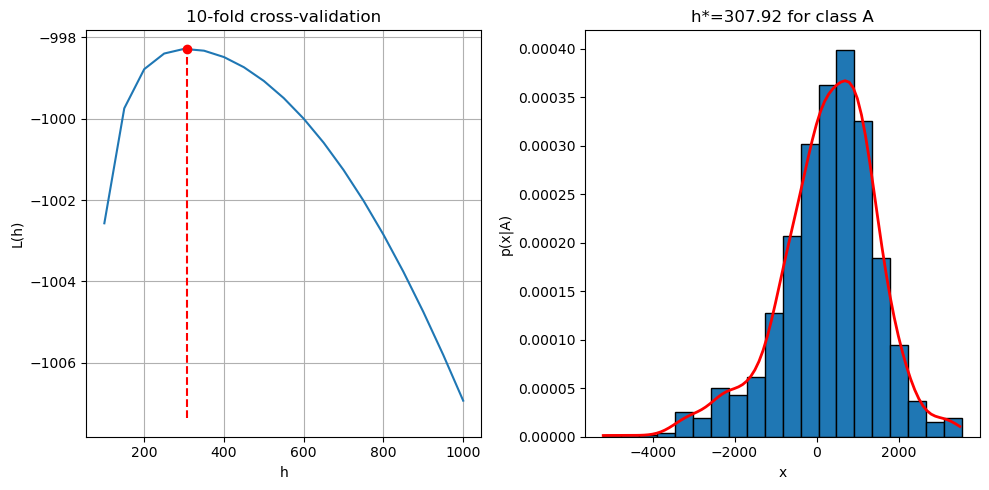

In [40]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(h_range, Lh)
plt.plot(h_bestA, Lh_bestA, 'or')
bottom, _ = plt.ylim()
plt.plot([h_bestA, h_bestA], [bottom, Lh_bestA], '--r');
plt.title('10-fold cross-validation')
plt.xlabel('h')
plt.ylabel('L(h)')
plt.grid('on')

y = parzen(x_range, xA, h_bestA)
plt.subplot(1, 2, 2)
plot_parzen(x_range, y, hist_A, bins_A, h=h_bestA)
plt.title(f'h*={h_bestA:.2f} for class A')
plt.tight_layout()
plt.savefig('optimal_h_classA.png')

### Class 'C' cross-validation

Now, repeat the previous steps to estimate the distribution of $p_{X|k}(x|C)$.

In [41]:
x_range = np.arange(np.min(xC), np.max(xC), 100)

np.random.seed(42)   # to get the same example outputs

num_data = xC.size
itrn, itst = crossval(num_data, num_folds)

Lh = np.zeros_like(h_range)
for i in range(len(h_range)):
    Lh[i] = compute_Lh(itrn, itst, xC, h_range[i])

#### Optimal value of parameter $h$

In [42]:
h_bestC = float(opt.fminbound(lambda h: -compute_Lh(itrn, itst, xC, float(h)), h_range[0], h_range[-1]))
Lh_bestC = compute_Lh(itrn, itst, xC, h_bestC)

#### Visualization of optimal $h$

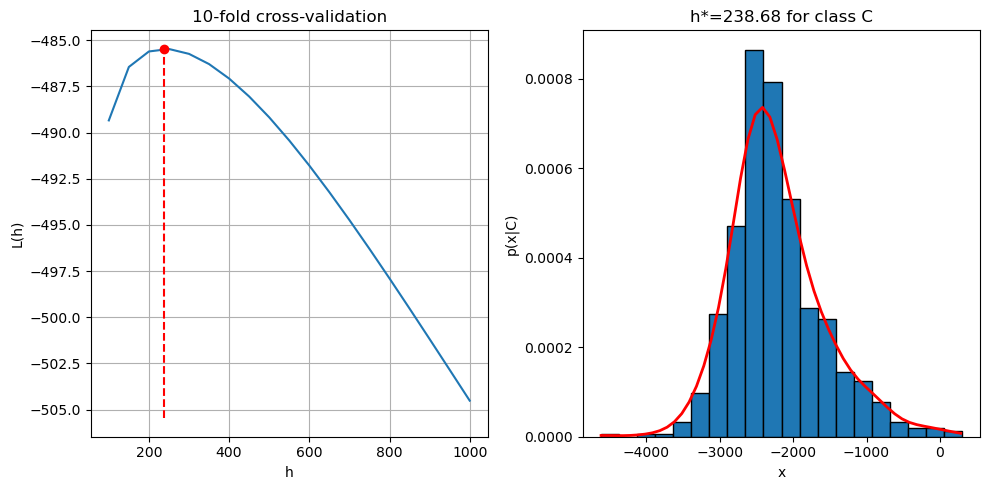

In [43]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(h_range, Lh)
plt.plot(h_bestC, Lh_bestC, 'or')
bottom, _ = plt.ylim()
plt.plot([h_bestC, h_bestC], [bottom, Lh_bestC], '--r');
plt.title('10-fold cross-validation')
plt.xlabel('h')
plt.ylabel('L(h)')
plt.grid('on')

y = parzen(x_range, xC, h_bestC)
plt.subplot(1, 2, 2)
plot_parzen(x_range, y, hist_C, bins_C, h=h_bestC, cls='C')
plt.title(f'h*={h_bestC:.2f} for class C')
plt.tight_layout()
plt.savefig('optimal_h_classC.png')

## Part 3 - Bayesian classifier

Use the estimated distributions $p_{X|k}(x|A)$ and $p_{X|k}(x|C)$ to create a Bayesian classifier with zero-one loss function. Estimate the a priori probabilities $p_K(A)$ and $p_K(C)$ on the training set as $$p_K(A) = \frac{N_A}{N_A + N_C},$$ where $N_A$ and $N_C$ are the counts of training samples of the respective classes (this is a Maximum-Likelihood estimate as discussed in the MLE-MAP-Bayes lab).

Then complete the template of the function `labels = classify_bayes_parzen(x_test, xA, xC, pA, pC, h_bestA, h_bestC)` which takes the measurements `x_test` computed on set `tst` and finds a label for each test example. Notice, that `parzen` returns a probability for any $x$, also for $x\in$ `tst`. No need for approximation, interpolation or similar techniques here!

In [44]:
x_test = compute_measurement_lr_cont(tst['images'])

# computing a priori probabilities
pA = len(xA) / (len(xA) + len(xC))
pC = len(xC) / (len(xA) + len(xC))

labels = classify_bayes_parzen(x_test, xA, xC, pA, pC, h_bestA, h_bestC)

### Show the classification

Do not forget to compute the Bayes error!

0.075


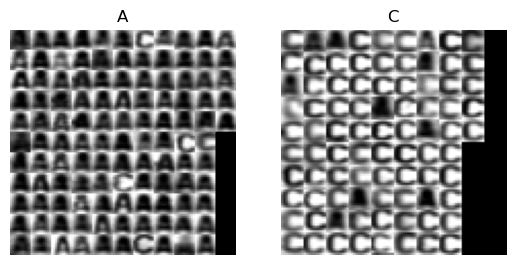

In [45]:
show_classification(tst['images'], labels, 'AC')
plt.savefig('parzen_classif.png')

# classification error
labels_true = tst['labels']
comparison = (labels != labels_true).astype(int)
bayes_error = (np.sum(comparison) / labels.shape[0]).astype(float)
print(bayes_error)

## Submission to the BRUTE Upload System

To fulfill this assignment, you need to submit these files (all packed in one ''.zip'' file) into the __[upload system](https://cw.felk.cvut.cz/brute/)__:
  - `parzen.ipynb` - a script for data initialization, calling of the implemented functions and plotting of their results (for your convenience, will not be checked)
  - `parzen.py` - containing the following implemented methods:
    - `parzen` - Parzen window estimator
    - `compute_Lh` - function for computing cross-validated log-likelihood ratio as a function of $h$
    - `classify_bayes_parzen` - classification using Parzen window density estimates
  - `parzen_estimates.png` - plots of estimates of $p_{X|k}(x|A)$ for varying $h$
  - `optimal_h_classA.png`, `optimal_h_classC.png` - graph with optimal bandwidth $h$ for class A and C respectively
  - `parzen_classif.png` - image with parzen classification

When preparing a zip file for the upload system, **do not include any directories**, the files have to be in the zip file root.


## Bonus task

Adapt your code to accept two dimensional measurements
  - x = (sum of pixel intensities in the **left** half of the image) - (sum of pixel intensities in the **right** half of the image)
  - y = (sum of pixel intensities in the **top** half of the image) - (sum of pixel intensities in the **bottom** half of the image)

The kernel function will now be a 2D normal distributions with diagonal covariance matrix `cov = sigma^2*eye(2)`. Display the estimated distributions $p_{X|k}(x|k)$.


## References
[1] __[Parzen window](https://en.wikipedia.org/wiki/Kernel_density_estimation)__

[2] __[Parzen Windows (Duda,Hart)](https://cw.fel.cvut.cz/wiki/_media/courses/be5b33rpz/labs/05_parzen/dhsch4part1.pdf)__

[3] __[Parzen Windows Method (V. Hlaváč)](https://cw.fel.cvut.cz/wiki/_media/courses/be5b33rpz/labs/05_parzen/neparametrodhady.pdf)__ in Czech

[4] __[Cross-validation](<https://en.wikipedia.org/wiki/Cross-validation_(statistics%29)>)__